In [1]:
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set() #set sns theme
#import matplotlib; matplotlib.rc_file_defaults() #set matplotlib theme

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Importing and adjusting the data

In [2]:
df_full = pd.read_csv("D:/corona/covid19_cat.csv", sep=',')

#working only with 2 columns (data and confirmed)
df = df_full[['date','totalCases']].copy()

#string to datetime and to ordinal
df['date']= pd.to_datetime(df['date']) 
df['date']=df['date'].map(datetime.datetime.toordinal)

remove_first_days = 30
df.drop(list(range(0, remove_first_days)), inplace=True)
df = df.reset_index(drop=True)

remove_last_days = 2
df.drop(list(df.iloc[-remove_last_days:].index), inplace=True) if remove_last_days > 0 else False
df = df.reset_index(drop=True)

#cleaning not informed days
remove_days = list(range(0,0))
df.drop(remove_days, inplace=True)
df = df.reset_index(drop=True)

df

,date,totalCases
0,737539,11
1,737540,13
2,737542,13
3,737543,13
4,737544,16
5,737545,20
6,737546,20
7,737549,27
8,737550,27
9,737551,33


### Adding pt_br format date column

In [3]:
def date_ordinal_to_br(date):
    ''' Receives a data in as ordinal, and converts it to a 
        string date in pt_br as: day/month_name
    '''
    date = datetime.datetime.fromordinal(date)
    date = format(date, "%d/%b")
    date = date.replace('Apr', 'abril').replace('May', 'maio').replace('Jun', 'junho')
    return date

days = list()
for day in df['date']:
    days.append(date_ordinal_to_br(day))
    
df['date_ptbr'] = pd.DataFrame(days)

## Adding future days - choose a number of 'future_days'
If future_days == 0, it will create a regression and no future prediction will be visible on the following plots

In [4]:
future_days = 10

for i in range(future_days):
    next_day = df.iloc[-1]['date'] + 1
    next_day_ptbr = date_ordinal_to_br(next_day)
    df = df.append(
            {'date_ptbr': next_day_ptbr,
             'date': next_day}, 
        ignore_index=True)

df.tail()

,date,totalCases,date_ptbr
26,737569,NaN,24/maio
27,737570,NaN,25/maio
28,737571,NaN,26/maio
29,737572,NaN,27/maio
30,737573,NaN,28/maio


## Creating a Linear Regression

In [5]:
X = pd.DataFrame(df['date'])
y = pd.DataFrame(df['totalCases'])

#treting confirmed as log
y = np.log(y)
y = y.replace([-np.inf], 0)

reg = LinearRegression()

reg.fit(X[:-future_days], y[:-future_days])
prediction = reg.predict(X)
prediction = np.exp(prediction)

#saving predicted values to the DataFrame
df['prediction'] = pd.DataFrame(prediction)
df['prediction'] = df['prediction']
y = pd.DataFrame(df['totalCases'])

#checking y data
print(y.head())
print(y.tail())

   totalCases
0        11.0
1        13.0
2        13.0
3        13.0
4        16.0
    totalCases
26         NaN
27         NaN
28         NaN
29         NaN
30         NaN


### Visually checking the linear regression

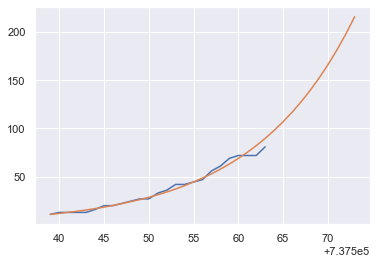

In [6]:
plt.plot(X, y)
plt.plot(X, df['prediction'])

## Verificando os valores de correlação entre os confirmados e a regressão

In [7]:
#automatically excludes NaN
cor = df['totalCases'].corr(df['prediction'])
cor_sq = cor **2

print("correlation: ", cor)
print("r^2", cor_sq)

correlation:  0.9880077361543559
r^2 0.9761592867008553


## Finding confidence cnterval (ci) -- not suitable for this data
If you conduct the same experiment 100 times, the mean for each sample would fall within the range of this confidence interval 95 times. 

There is a 95% probability that the confidence interval contains the population's true mean

mean = float(df['prediction'].mean())
n = len(df['prediction'])

ci = 1.96 * np.sqrt(mean**2 / n)

print('confidence interval (ci): ', ci)

#saving upper and lower confidence values to DataFrame
df['prediction_uc'] = df['prediction'] + ci
df['prediction_lc'] = df['prediction'] - ci

### Finding mean squared error (mse) and root mean squared error (rmse)

In [8]:
mse = mean_squared_error(df['totalCases'][:-future_days], df['prediction'][:-future_days])
df['prediction_u_mse'] = df['prediction'] + mse
df['prediction_l_mse'] = df['prediction'] - mse

rmse = np.sqrt(mse)  #y_true, y_pred
df['prediction_u_rmse'] = df['prediction'] + rmse
df['prediction_l_rmse'] = df['prediction'] - rmse

print('mean squared error (mse): ', mse)
print('root mean squared error (rmse): ', rmse)

mean squared error (mse):  14.330939537016485
root mean squared error (rmse):  3.785622740978885


In [9]:
from sklearn.metrics import r2_score
r2 = r2_score(df['totalCases'][:-future_days],df['prediction'][:-future_days])
print("correlation: ", r2 ** 0.5)
print("r^2", r2)

correlation:  0.9864177889743748
r^2 0.9730200544050943


### Summary of the dataset
And saving it to a new file. It now contains more data than the original dataset

In [10]:
df.to_csv('D:\corona\covid19_cat_predictions.csv', index=False)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date,31.0,737557.064516,10.269487,737539.000000,737549.500000,737558.000000,737565.500000,737573.000000
totalCases,21.0,40.142857,23.616278,11.000000,20.000000,36.000000,61.000000,81.000000
prediction,31.0,75.675303,60.005391,10.910034,27.453223,57.845159,111.853308,215.870874
prediction_u_mse,31.0,90.006243,60.005391,25.240974,41.784162,72.176099,126.184247,230.201814
prediction_l_mse,31.0,61.344363,60.005391,-3.420905,13.122283,43.514219,97.522368,201.539935
prediction_u_rmse,31.0,79.460926,60.005391,14.695657,31.238845,61.630782,115.638931,219.656497
prediction_l_rmse,31.0,71.889680,60.005391,7.124411,23.667600,54.059536,108.067685,212.085252


## Ploting real data + linear regression + error area

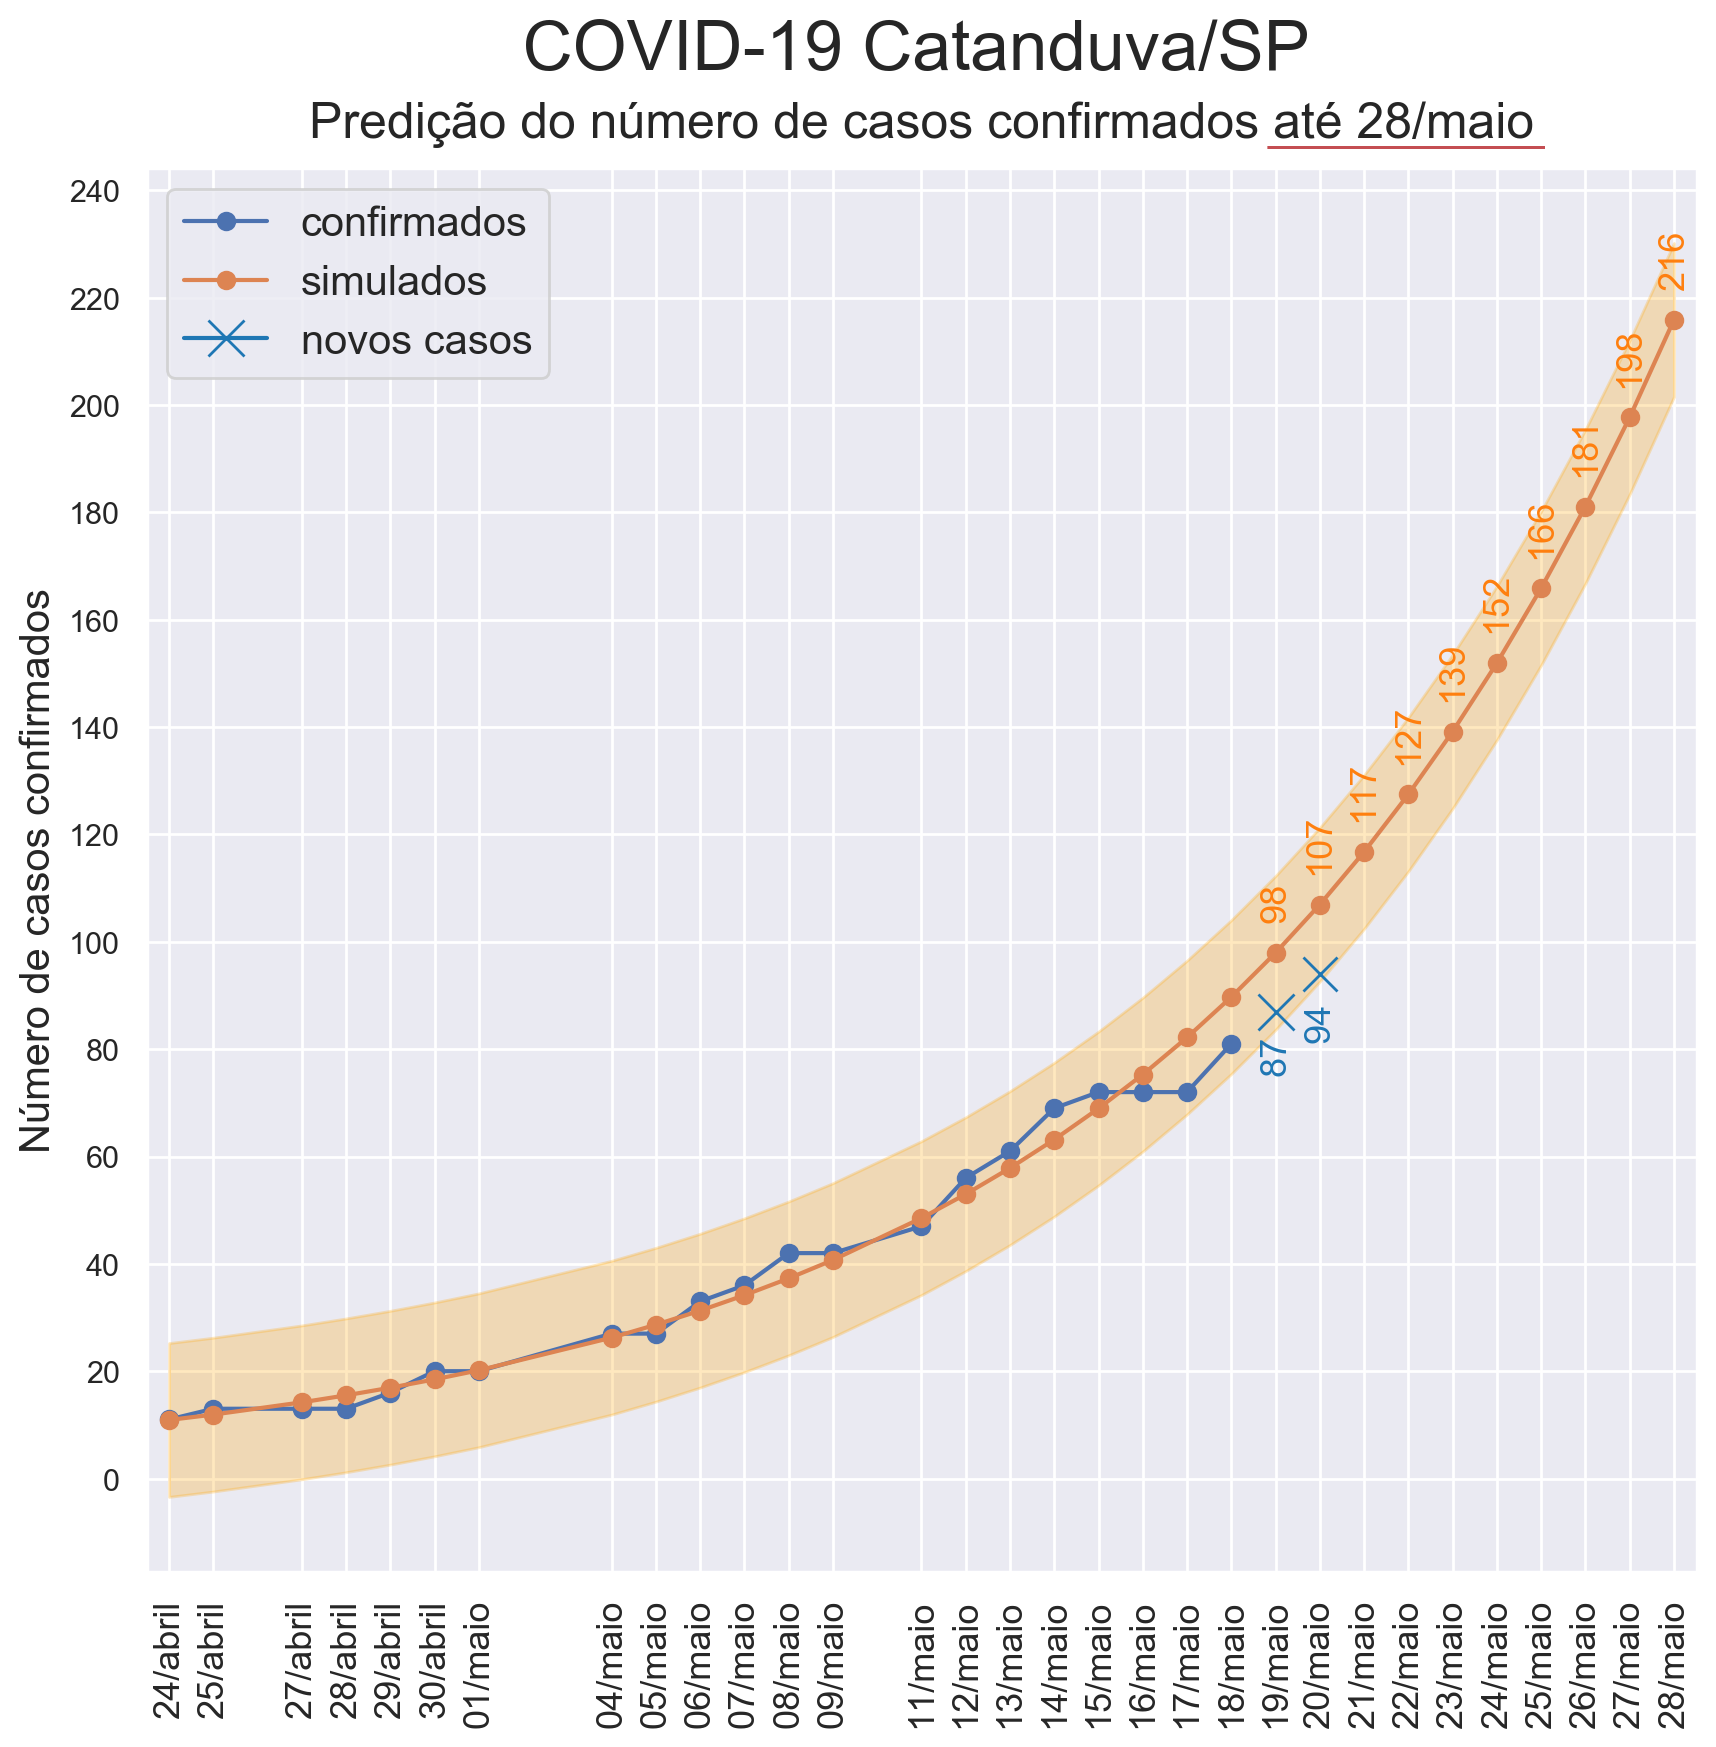

In [11]:
file_output = 'D:\corona\plots\catanduva\covid_cat_20200518.png'

plt.rcParams["figure.dpi"] = 200
plt.figure(figsize=(10,9.3))
plt.margins(x=0.015)
plt.margins(y=0.06)
# plt.grid(color='grey', linewidth=.25, axis = 'both')
plt.yticks(np.arange(0, 1000, step=20))
plt.xticks(df['date'], 
           df['date_ptbr'], 
           rotation=90,
          fontsize=13)

plt.plot(X, y, '-o')
plt.plot(X, df['prediction'],'-o')

# new confirmed: 16/05/2020
dist_up = 1.03
dist_down = 0.88
plt.plot(737564, 87, marker='x', markersize=13, color='tab:blue')
plt.text(737564, 87*dist_down, '87', color='tab:blue',rotation=90, fontsize=13,horizontalalignment='center')
plt.plot(737565, 94, marker='x', markersize=12, color='tab:blue')
plt.text(737565, 94*dist_down, '94', color='tab:blue',rotation=90, fontsize=13,horizontalalignment='center')


plt.figtext(0.755, 0.895, "____________", fontsize=15, color='r', ha ='center')
plt.suptitle("  COVID-19 Catanduva/SP", y=.96, fontsize=25, horizontalalignment='center')
plt.title("Predição do número de casos confirmados até "+df.at[len(df)-1,'date_ptbr'], y=1.01, fontsize=18)

# plt.xlabel('Data', labelpad=10, fontsize=12)
plt.ylabel("Número de casos confirmados", fontsize=15)
plt.legend(['confirmados', 'simulados', 'novos casos'], loc='upper left', prop={'size': 15})

#Plot Confidence interval
lc = df['prediction_l_mse'], df['prediction_l_rmse'], df['prediction'] * 0.5 #prediction_lc
uc = df['prediction_u_mse'], df['prediction_u_rmse'], df['prediction'] * 1.5 #prediction_uc

# plt.fill_between(np.ravel(X),lc[2],uc[2] , alpha=.1, color = 'green') #x_values, y_from, y_to
# plt.fill_between(np.ravel(X),lc[1],uc[1] , alpha=.15, color = 'orange') #x_values, y_from, y_to
plt.fill_between(np.ravel(X),lc[0],uc[0] , alpha=.25, color = 'orange') #x_values, y_from, y_to

#data points legends
''' if 'future_days == 0' it show the values of all days (there is no prediction)
    if 'future_days > 0' it shows only the values for predicted days+
'''
for pos_x, pos_y in zip(np.ravel(X['date'][-future_days:]), np.ravel(prediction[-future_days:])):
    plt.text(pos_x,pos_y+7,int(pos_y.round(0)),rotation=90, fontsize=13, 
             horizontalalignment='center', color='tab:orange')

plt.savefig(file_output, bbox_inches = "tight") #tight removes extra surrounding white spaces
# plt.show()

In [12]:
df

,date,totalCases,date_ptbr,prediction,prediction_u_mse,prediction_l_mse,prediction_u_rmse,prediction_l_rmse
0,737539,11.0,24/abril,10.910034,25.240974,-3.420905,14.695657,7.124411
1,737540,13.0,25/abril,11.911174,26.242114,-2.419765,15.696797,8.125552
2,737542,13.0,27/abril,14.197488,28.528428,-0.133451,17.983111,10.411866
3,737543,13.0,28/abril,15.500296,29.831235,1.169356,19.285919,11.714673
4,737544,16.0,29/abril,16.922653,31.253593,2.591714,20.708276,13.137031
5,737545,20.0,30/abril,18.475531,32.806470,4.144591,22.261154,14.689908
6,737546,20.0,01/maio,20.170905,34.501845,5.839966,23.956528,16.385283
7,737549,27.0,04/maio,26.248881,40.579821,11.917942,30.034504,22.463259
8,737550,27.0,05/maio,28.657564,42.988503,14.326624,32.443187,24.871941
9,737551,33.0,06/maio,31.287275,45.618214,16.956335,35.072898,27.501652
